In [1]:
import sys
from pathlib import Path

sys.path.append(str(Path('.').resolve().parent))

In [76]:
from copy import deepcopy

import medmnist
from medmnist import INFO, VesselMNIST3D, AdrenalMNIST3D
from medmnist.evaluator import getACC, getAUC

from lightning import seed_everything

from imea import shape_measurements_3d
from imea.measure_3d.utils import compute_convexhull
from imea.measure_3d.macro import feret_and_max_dimensions_3d

from scipy.spatial import ConvexHull

import torch
from torch import nn
from torch.utils.data import DataLoader
import pandas as pd

from sklearn.metrics import r2_score

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange

from posenc.modules.mnistmodel import MNISTModel
from posenc.enums import PatchEmbeddingType, PosEncType


seed_everything(42)

INPUT_DIM = 258

MNISTROOT = "/sc-scratch/sc-scratch-gbm-radiomics/medmnist"
B_INIT = torch.randn(INPUT_DIM // 2, 3).to("cuda")

sns.set_theme("paper", style="whitegrid", font_scale=1.5)

[rank: 0] Seed set to 42


# Define Dataclass, Model and PEs

In [3]:
from monai.transforms import Resize

In [98]:
def get_feret_diameter(img):
    if img.ndim == 4:
        img = img[0]

    x, y, z = np.where(img)
    coords = np.stack([x, y, z], axis=1)
    ch = ConvexHull(coords)

    if len(ch.points) < 10:
        return 1, 1 # Can't compute this for very tiny shapes

    return feret_and_max_dimensions_3d(ch, spatial_resolution=1)[:2]

    
def pad_or_sample_points(encoded_points: np.ndarray, max_points: int):
    """
    Args:
        encoded_points (np.ndarray): Array of shape (N, D) with N encoded points
        max_points (int): Desired fixed number of points

    Returns:
        padded_or_sampled (np.ndarray): (max_points, D)
        mask (np.ndarray): (max_points,) bool array. True for real points, False for padded.
    """
    N, D = encoded_points.shape

    if N == max_points:
        return encoded_points, np.ones(max_points, dtype=bool)

    if N < max_points:
        # Pad with random encodings
        num_pad = max_points - N
        random_encodings = np.random.uniform(-1, 1, size=(num_pad, D))  # or use normal
        padded = np.vstack([encoded_points, random_encodings])
        mask = np.zeros(max_points, dtype=bool)
        mask[:N] = True
        return padded, mask

    indices = np.random.choice(N, max_points, replace=False)
    sampled = encoded_points[indices]
    mask = np.ones(max_points, dtype=bool)
    return sampled, ~mask



class FeretDiameterDataset:
    def __init__(self, split="train", size=28, anisotropy=[1, 1, 1], max_points=128, adrenal=True):
        if adrenal:
            self.dataset = AdrenalMNIST3D(root=MNISTROOT, split=split, size=size)
        else:
            self.dataset = VesselMNIST3D(root=MNISTROOT, split=split, size=size)
        self.size = size
        self.anisotropy = anisotropy
        self.max_points = max_points

        self.resize = Resize(spatial_size=[size, size, size], mode="nearest")
        
    def setup(self):
        self._ferets = []
        for img, _ in tqdm(self.dataset):
            self._ferets.append(get_feret_diameter(img))

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        img, _ = self.dataset[index]
        
        img = img[:, ::self.anisotropy[0], ::self.anisotropy[1], ::self.anisotropy[2]]
        img = self.resize(img) 

        img = img.squeeze()
        x, y, z = np.where(img)

        points = np.stack([x, y, z], axis=1) / img.shape

        fd_max, fd_min = self._ferets[index]

        mask = None
        if self.max_points:
            points, mask = pad_or_sample_points(points, self.max_points)
            mask = torch.tensor(mask, dtype=torch.bool)


        points = torch.tensor(points, dtype=torch.float32)
        fd = torch.tensor([fd_max, fd_min])
        
        return points, mask, fd

In [5]:
def process_gaussian(B, scale=[1, 1, 1]):
    # Normalize each column to have std=1
    std = B.std(dim=0, keepdim=True)
    B = B / std.clamp(min=1e-8)

    # Apply per-dimension scaling
    return B * torch.tensor(scale, device=B.device, dtype=B.dtype)

def input_mapping(x, B):
    """
    x: (B, N, D)  - batched points
    B: (M, D)     - Fourier basis
    returns: (B, N, 2*M)
    """
    # x: (B, N, D), B.T: (D, M) => x_proj: (B, N, M)
    x_proj = torch.matmul(x, B.t()) * (2 * np.pi)
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)  # (B, N, 2M)

def afpe(points, scale=[1, 1, 1]):
    """
    points: (B, N, 3)
    scale: length-3 list to scale each axis in B
    """
    B = process_gaussian(B_INIT, scale)
    return input_mapping(points, B)

def sinusoidal_encoding(points, hidden_size=258, temperature=10000.0):
    """
    points: (B, N, 3)
    returns: (B, N, hidden_size)
    """
    assert hidden_size % 6 == 0, "hidden_size must be divisible by 6"

    pos_dim = hidden_size // 6  # per sine/cosine per axis
    omega = torch.arange(pos_dim, dtype=torch.float32, device=points.device)
    omega = 1.0 / (temperature ** (omega / pos_dim))  # (pos_dim,)

    embeddings = []
    for i in range(3):  # for x, y, z
        coord = points[:, :, i]  # (B, N)
        scaled = coord.unsqueeze(-1) * omega  # (B, N, pos_dim)
        embeddings.append(torch.sin(scaled))
    for i in range(3):
        coord = points[:, :, i]
        scaled = coord.unsqueeze(-1) * omega
        embeddings.append(torch.cos(scaled))

    return torch.cat(embeddings, dim=-1)  # (B, N, hidden_size)


# Neural Network Definition
class SimpleNetWithMask(nn.Module):
    def __init__(self, num_layers, input_dim, num_channels=126, encoding="spe", scale=[1, 1, 1], dropout_p=0.0):
        super().__init__()

        self.num_channels = num_channels
        self.input_dim = input_dim
        self.encoding = encoding

        self.scale = scale
        
        layers = []
        layers.append(nn.Linear(input_dim, num_channels))
        layers.append(nn.ReLU())

        for _ in range(num_layers - 2):
            layers.append(nn.Linear(num_channels, num_channels))
            layers.append(nn.ReLU())
        
        self.encoder = nn.Sequential(*layers)
        self.dropout = nn.Dropout(dropout_p)
        self.output_head = nn.Linear(num_channels, 2)  # final output layer

    @torch.no_grad()
    def _encode_points(self, points):
        if self.encoding == "spe":
            return sinusoidal_encoding(points)
        if self.encoding == "fpe":
            b = process_gaussian(B_INIT)
            return input_mapping(points, b)
        if self.encoding == "afpe":
            b = process_gaussian(B_INIT, self.scale)
            return input_mapping(points, b)
        raise
    
    def forward(self, x, mask):
        """
        x: (B, N, D) input points embeddings
        mask: (B, N) boolean mask, True for real points, False for padding
        """
        B, N, _ = x.shape

        x = self._encode_points(x)
        
        x = self.encoder(x)  # (B, N, C)

        # Mask out padded points before pooling
        # Set padding points to a very large negative number for max pooling
        masked_x = x.masked_fill(mask.unsqueeze(-1), float('-inf'))

        # Global max pooling over points dimension
        pooled, _ = masked_x.max(dim=1)  # (B, C)

        # Replace -inf pooled values (if any example had all padding) by zeros
        pooled[pooled == float('-inf')] = 0

        pooled = self.dropout(pooled)

        # Pass pooled features through output head
        out = self.output_head(pooled)  # (B, 1)
        return out

# Prepare Adrenal datasets

In [6]:
train_dataset = FeretDiameterDataset(split="train", adrenal=True)
train_dataset.setup()

valid_dataset = FeretDiameterDataset(split="val", adrenal=True)
valid_dataset.setup()

test_dataset = FeretDiameterDataset(split="test", adrenal=True)
test_dataset.setup()

100%|██████████| 298/298 [00:04<00:00, 64.57it/s]


In [7]:
train_ferets = train_dataset._ferets
valid_ferets = valid_dataset._ferets
test_ferets = test_dataset._ferets

# Train

In [59]:
def train(model, loader, optimizer, loss_fn):
    epoch_loss = 0
    for i, (x, m, y) in enumerate(loader):
    
        x = x.to("cuda").float()
        y = y.to("cuda").float()
        m = m.to("cuda")
    
        pred = model(x, m)
    
        loss = loss_fn(pred, y)
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(loader.dataset)

def validate(model, loader, loss_fn):
    with torch.no_grad():
        epoch_loss = 0
        p_min_feret = []
        p_max_feret = []
        
        y_min_feret = []
        y_max_feret = []
        
        for i, (x, m, y) in enumerate(loader):
        
            x = x.to("cuda").float()
            y = y.to("cuda").float()
            m = m.to("cuda")

            pred = model(x, m)
        
            loss = loss_fn(pred, y)
    
            epoch_loss += loss.item()
            p_max_feret += pred[:, 0].tolist()
            p_min_feret += pred[:, 1].tolist()
            
            y_max_feret += y[:, 0].tolist()
            y_min_feret += y[:, 1].tolist()
    
        epoch_loss = epoch_loss / len(loader.dataset)
        r2_max_feret = r2_score(y_max_feret, p_max_feret)
        r2_min_feret = r2_score(y_min_feret, p_min_feret)

        return epoch_loss, r2_max_feret, r2_min_feret

def test(model, loader):
    with torch.no_grad():
        predictions = []
        ys = []
        for i, (x, m, y) in enumerate(loader):
        
            x = x.to("cuda").float()
            y = y.to("cuda").float()
            m = m.to("cuda")

            pred = model(x, m)
    
            predictions += pred.tolist()
            ys += y.tolist()
    
        return predictions, ys

In [64]:
performance = []
test_perfor = []

for anisotropy in [(1, 1, 3), (1, 1, 5)]:
    train_dataset = FeretDiameterDataset(split="train", anisotropy=anisotropy, size=64, max_points=1377)
    train_dataset._ferets = train_ferets
    train_loader = DataLoader(train_dataset, batch_size=8, num_workers=8, prefetch_factor=2, shuffle=False, pin_memory=True)
    
    valid_dataset = FeretDiameterDataset(split="val", anisotropy=anisotropy, size=64, max_points=1377)
    valid_dataset._ferets = valid_ferets
    valid_loader = DataLoader(valid_dataset, batch_size=8, num_workers=8)

    test_dataset = FeretDiameterDataset(split="test", anisotropy=anisotropy, size=64, max_points=1377)
    test_dataset._ferets = test_ferets
    test_loader = DataLoader(test_dataset, batch_size=8, num_workers=8)
    
    for encoding in ["afpe", "spe", "fpe"]:

        best_model = None
        best_score = float("inf")

        if "fpe":
            scale = np.array([1, 1, 1])
        else:
            scale = np.array(anisotropy) * 0.5
        
        model = SimpleNetWithMask(num_layers=3, num_channels=256, input_dim=INPUT_DIM, encoding="spe" if encoding == "spe" else "afpe", scale=scale).to("cuda")

        with torch.no_grad():
            # Set bias to mean regression value from training dataset for fast convergence
            mean_train_output = torch.tensor(np.stack(train_dataset._ferets).mean(axis=0), dtype=torch.float32)
            model.output_head.bias.copy_(mean_train_output)        
        
        loss_fn = nn.MSELoss()
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0)
        
        
        train_losses = []
        valid_losses = []
        
        for epoch in trange(15):
            train_loss = train(model, train_loader, optimizer, loss_fn)
            valid_loss, r2_max_feret, r2_min_feret = validate(model, valid_loader, loss_fn)
        
            performance.append({"method": encoding, "anisotropy": anisotropy[-1], "epoch": epoch, "r2-max": r2_max_feret, "r2-min": r2_min_feret, "train_loss": train_loss, "valid_loss": valid_loss})

            if valid_loss < best_score:
                best_score = valid_loss
                best_model = deepcopy(model).cpu() 


        best_model = best_model.to("cuda")
        preds, ys = test(best_model, test_loader)

        test_perfor.append((encoding, anisotropy[-1], preds, ys))

performance = pd.DataFrame(performance)

100%|██████████| 15/15 [00:19<00:00,  1.30s/it]


# Test performance with bootstrapping

In [73]:
test_df = []
for method, anisotropy, p, y in test_perfor:
    p = np.array(p)
    y = np.array(y)

    for i in range(100):

        indeces = np.random.choice(np.arange(len(p)), size=len(p))
        y_, p_ = y[indeces], p[indeces]
        
        r2_max = r2_score(y_[:, 0], p_[:, 0])
        r2_min = r2_score(y_[:, 1], p_[:, 1])

        mse = np.mean((y_ - p_) ** 2)
        mae = np.mean(np.abs(y_ - p_))

        test_df.append({"method": method, "anisotropy": anisotropy, "r2-min": r2_min, "r2-max": r2_max, "mse": mse, "mae": mae, "boot": i})
test_df = pd.DataFrame(test_df)

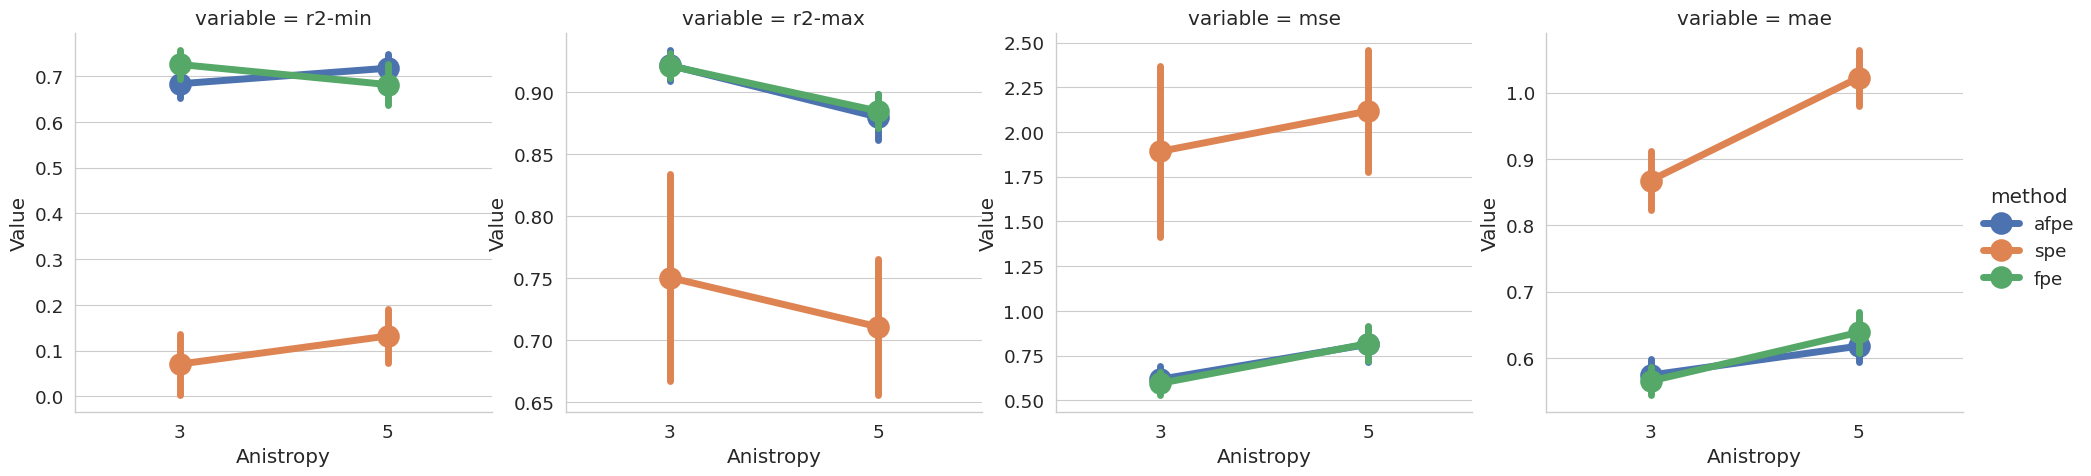

In [118]:
f = sns.catplot(test_df.melt(id_vars=["anisotropy", "method", "boot"]), x="anisotropy", y="value", kind="point", hue="method", col="variable", sharey=False, lw=5, errorbar=("sd", 1))
f.set(xlabel="Anistropy", ylabel="Value")

In [117]:
test_df.groupby(["anisotropy", "method"]).agg(["mean", "std"]).loc[:, ["r2-min", "r2-max"]].round(3)

r2-min        r2-max       
                    mean    std   mean    std
anisotropy method                            
3          afpe    0.683  0.031  0.922  0.013
           fpe     0.725  0.032  0.921  0.010
           spe     0.071  0.067  0.750  0.083
5          afpe    0.717  0.032  0.880  0.019
           fpe     0.681  0.045  0.885  0.014
           spe     0.132  0.059  0.711  0.055

# Prepare Vessel Dataset

In [99]:
train_dataset = FeretDiameterDataset(split="train", adrenal=False)
train_dataset.setup()

valid_dataset = FeretDiameterDataset(split="val", adrenal=False)
valid_dataset.setup()

test_dataset = FeretDiameterDataset(split="test", adrenal=False)
test_dataset.setup()

100%|██████████| 382/382 [00:06<00:00, 62.73it/s]


In [100]:
train_ferets = train_dataset._ferets
valid_ferets = valid_dataset._ferets
test_ferets = test_dataset._ferets

# Train of Vessel data

In [111]:
performance = []
test_perfor = []

for anisotropy in [(1, 1, 3), (1, 1, 5)]:
    train_dataset = FeretDiameterDataset(split="train", anisotropy=anisotropy, size=64, max_points=1377, adrenal=False)
    train_dataset._ferets = train_ferets
    train_loader = DataLoader(train_dataset, batch_size=8, num_workers=8, prefetch_factor=2, shuffle=False, pin_memory=True)
    
    valid_dataset = FeretDiameterDataset(split="val", anisotropy=anisotropy, size=64, max_points=1377, adrenal=False)
    valid_dataset._ferets = valid_ferets
    valid_loader = DataLoader(valid_dataset, batch_size=8, num_workers=8)

    test_dataset = FeretDiameterDataset(split="test", anisotropy=anisotropy, size=64, max_points=1377, adrenal=False)
    test_dataset._ferets = test_ferets
    test_loader = DataLoader(test_dataset, batch_size=8, num_workers=8)
    
    for encoding in ["afpe", "spe", "fpe"]:

        best_model = None
        best_score = float("inf")

        if "fpe":
            scale = np.array([1, 1, 1])
        else:
            scale = np.array(anisotropy) * 0.5
        
        model = SimpleNetWithMask(num_layers=3, num_channels=256, input_dim=INPUT_DIM, encoding="spe" if encoding == "spe" else "afpe", scale=scale).to("cuda")

        with torch.no_grad():
            # Set bias to mean regression value from training dataset for fast convergence
            mean_train_output = torch.tensor(np.stack(train_dataset._ferets).mean(axis=0), dtype=torch.float32)
            model.output_head.bias.copy_(mean_train_output)        
        
        loss_fn = nn.MSELoss()
        optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.0)
        
        
        train_losses = []
        valid_losses = []
        
        for epoch in trange(15):
            train_loss = train(model, train_loader, optimizer, loss_fn)
            valid_loss, r2_max_feret, r2_min_feret = validate(model, valid_loader, loss_fn)
        
            performance.append({"method": encoding, "anisotropy": anisotropy[-1], "epoch": epoch, "r2-max": r2_max_feret, "r2-min": r2_min_feret, "train_loss": train_loss, "valid_loss": valid_loss})

            if valid_loss < best_score:
                best_score = valid_loss
                best_model = deepcopy(model).cpu() 


        best_model = best_model.to("cuda")
        preds, ys = test(best_model, test_loader)

        test_perfor.append((encoding, anisotropy[-1], preds, ys))

performance = pd.DataFrame(performance)

100%|██████████| 15/15 [00:22<00:00,  1.52s/it]


In [114]:
vessel_test_df = []
for method, anisotropy, p, y in test_perfor:
    p = np.array(p)
    y = np.array(y)

    for i in range(100):

        indeces = np.random.choice(np.arange(len(p)), size=len(p))
        y_, p_ = y[indeces], p[indeces]
        
        r2_max = r2_score(y_[:, 0], p_[:, 0])
        r2_min = r2_score(y_[:, 1], p_[:, 1])

        mse = np.mean((y_ - p_) ** 2)
        mae = np.mean(np.abs(y_ - p_))

        vessel_test_df.append({"method": method, "anisotropy": anisotropy, "r2-min": r2_min, "r2-max": r2_max, "mse": mse, "mae": mae, "boot": i})
vessel_test_df = pd.DataFrame(vessel_test_df)

In [116]:
vessel_test_df.groupby(["anisotropy", "method"]).agg(["mean", "std"]).loc[:, ["r2-min", "r2-max"]].round(3)

r2-min        r2-max       
                    mean    std   mean    std
anisotropy method                            
3          afpe    0.624  0.028  0.919  0.009
           fpe     0.635  0.025  0.913  0.014
           spe     0.076  0.026  0.061  0.036
5          afpe    0.587  0.035  0.896  0.014
           fpe     0.527  0.036  0.902  0.015
           spe     0.060  0.024  0.101  0.032

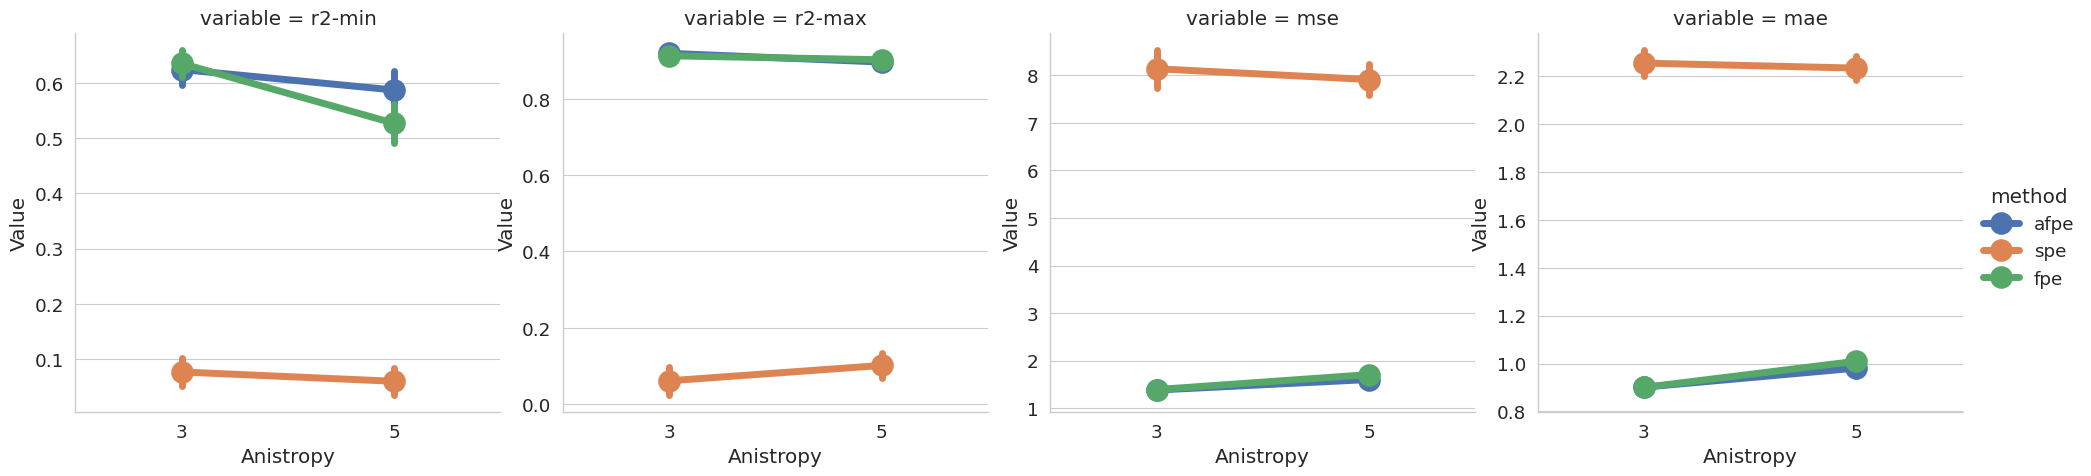

In [119]:
f = sns.catplot(test_df.melt(id_vars=["anisotropy", "method", "boot"]), x="anisotropy", y="value", kind="point", hue="method", col="variable", sharey=False, lw=5, errorbar=("sd", 1))
f.set(xlabel="Anistropy", ylabel="Value")